# Dependencies

In [ ]:
# External imports
import torch
import pandas as pd
from skimage.measure.entropy import shannon_entropy
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [4]:
agricultural_data_path = "../data/CloudPlast"
df = pd.read_csv(f"{agricultural_data_path}/raw_and_masked_data.csv")
df

,name,raw_R_entropy,raw_G_entropy,raw_B_entropy,raw_total_objects,raw_total_area,name.1,masked_R_entropy,masked_G_entropy,masked_B_entropy,masked_total_objects,masked_total_area,cloud_area,cloud_percentage,R_entropy_diff,G_entropy_diff,B_entropy_diff,total_objects_diff,delta_no
0,ImgROI_0_Tile_00_Date_20240603.tif,8.666293,8.613922,7.995633,28,82754,ImgROI_0_Tile_00_Date_20240603.tif,6.743862,6.590894,6.443283,28,84163,2329,3.55,1.922431,2.023028,1.552350,0,0.0
1,ImgROI_0_Tile_00_Date_20240608.tif,8.612544,8.692014,8.021397,25,81664,ImgROI_0_Tile_00_Date_20240608.tif,7.765017,7.609489,7.520390,25,77848,2652,4.05,0.847527,1.082525,0.501006,0,0.0
2,ImgROI_0_Tile_00_Date_20240613.tif,8.229535,7.969302,7.428288,33,85613,ImgROI_0_Tile_00_Date_20240613.tif,7.927564,7.928014,7.999233,33,85613,0,0.00,0.301971,0.041289,-0.570945,0,0.0
3,ImgROI_0_Tile_00_Date_20240618.tif,8.236620,8.052459,7.438781,33,86850,ImgROI_0_Tile_00_Date_20240618.tif,8.021036,8.041166,8.043915,33,86850,0,0.00,0.215584,0.011294,-0.605134,0,0.0
4,ImgROI_0_Tile_00_Date_20240623.tif,8.379305,8.452377,8.393192,0,0,ImgROI_0_Tile_00_Date_20240623.tif,1.808431,1.924458,1.933028,2,3941,61670,94.10,6.570873,6.527919,6.460164,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,ImgROI_0_Tile_49_Date_20240906.tif,10.277830,9.480681,9.544454,107,101701,ImgROI_0_Tile_49_Date_20240906.tif,8.848960,8.861636,8.916644,107,101701,0,0.00,1.428870,0.619045,0.627811,0,0.0
1196,ImgROI_0_Tile_49_Date_20240911.tif,10.377738,9.608532,9.645413,106,105456,ImgROI_0_Tile_49_Date_20240911.tif,8.922040,8.999674,8.880504,106,105456,0,0.00,1.455698,0.608858,0.764909,0,0.0
1197,ImgROI_0_Tile_49_Date_20240916.tif,10.258128,9.522816,9.573575,107,83258,ImgROI_0_Tile_49_Date_20240916.tif,8.939631,8.864963,8.917307,107,83258,0,0.00,1.318497,0.657853,0.656269,0,0.0
1198,ImgROI_0_Tile_49_Date_20240921.tif,10.178098,9.451790,9.369512,109,120654,ImgROI_0_Tile_49_Date_20240921.tif,8.917555,8.898309,8.963069,109,120654,0,0.00,1.260543,0.553481,0.406443,0,0.0


# Results

This agricultural dataset consists of 50 sample points with 24 images over time for each point.

Here you'll find the code to generate Figures 5 and 6 from the Article.

In [5]:
sample_points = []

for sample_id in range(50):  
    sample_str = f"Tile_{sample_id:02d}"
    point_images = df[df.iloc[:, 0].str.contains(sample_str, case=False)]
    sample_points.append(point_images)

print(f"Number of sample points: {len(sample_points)}")
print(f"Number of images per sample point: {[len(images) for images in sample_points]}")


Number of sample points: 50
Number of images per sample point: [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


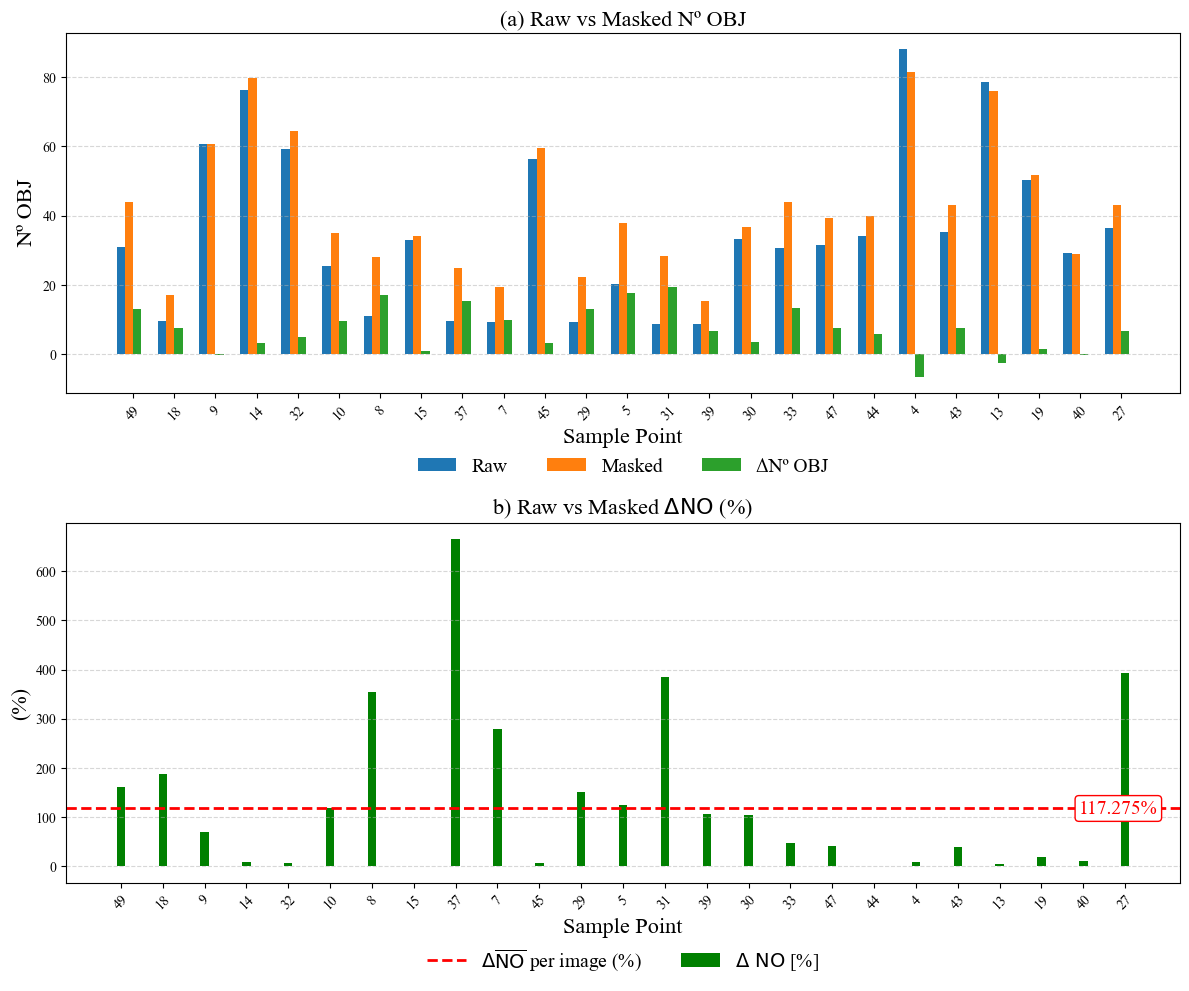

In [10]:
plt.rcParams['font.family'] = 'Times New Roman'

sample_labels = [f"SAMPLE_{i:02d}" for i in range(0, 50, 1)]

avg_metrics = {
    'raw_total_objects': [],
    'masked_total_objects': [],
    'total_objects_diff': [],
    'total_diff_percentage': [],
    'delta_no': []
}

for sample_point in sample_points:
    sample_point = sample_point[(sample_point['cloud_percentage'] > 10) & (sample_point['cloud_percentage'] < 90)]

    avg_metrics['raw_total_objects'].append(sample_point['raw_total_objects'].mean())
    avg_metrics['masked_total_objects'].append(sample_point['masked_total_objects'].mean())
    avg_metrics['total_objects_diff'].append(sample_point['total_objects_diff'].mean())
    avg_metrics['total_diff_percentage'].append(
        ((sample_point["masked_total_objects"].mean() - sample_point["raw_total_objects"].mean()) / sample_point["raw_total_objects"].mean()) * 100
        if sample_point["raw_total_objects"].mean() != 0 else 0
    )
    avg_metrics['delta_no'].append(sample_point["delta_no"].mean())

# Setup subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 10))

x = np.arange(len(sample_labels))
width = 0.2

# Select 25 random samples
random_selection = pd.DataFrame(avg_metrics).sample(n=25, random_state=41)

# --- First subplot: Absolute values ---
rects1 = ax1.bar(x[:25] - 1.5*width, random_selection['raw_total_objects'], width, label='Raw')
rects2 = ax1.bar(x[:25] - 0.5*width, random_selection['masked_total_objects'], width, label='Masked')
rects3 = ax1.bar(x[:25] + 0.5*width, random_selection['total_objects_diff'], width, label='ΔNº OBJ')

ax1.set_ylabel('Nº OBJ', fontsize=16)
ax1.set_title('(a) Raw vs Masked Nº OBJ', fontsize=16)
ax1.set_xlabel('Sample Point', fontsize=16)
ax1.set_xticks(x[:25])
ax1.set_xticklabels(random_selection.index, rotation=45)
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3, fontsize=14, frameon=False)

# --- Second subplot: Percentage difference ---
rects4 = ax2.bar(x[:25], random_selection['delta_no'], width, color='green', label=r'$\Delta\ {\mathrm{NO}}$ [%]')

# Add average line with value annotation
filtered_merged_df = df[(df['cloud_percentage'] > 10) & (df['cloud_percentage'] < 90)]

delta_no = filtered_merged_df["delta_no"].mean()

avg_line = ax2.axhline(y=delta_no, color='red', linestyle='--', 
                        linewidth=2, label=r'$\Delta \overline{\mathrm{NO}}$ per image (%)')

# Add average value text annotation
ax2.annotate(f'{delta_no:.3f}%',
            xy=(0.98, delta_no),
            xycoords=('axes fraction', 'data'),
            ha='right', va='center',
            color='red', fontsize=14,
            bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))

ax2.set_ylabel('(%)', fontsize=16)
ax2.set_xlabel('Sample Point', fontsize=16)
ax2.set_title(r'b) Raw vs Masked $\Delta {\mathrm{NO}}$ (%)', fontsize=16)
ax2.set_xticks(x[:25])
ax2.set_xticklabels(random_selection.index, rotation=45)
ax2.grid(True, axis='y', linestyle='--', alpha=0.5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=2, frameon=False, fontsize=14)

plt.tight_layout()
# plt.savefig("Figure7.png", dpi=300)
plt.show()

/home/fekenzofugi/miniconda3/envs/env/lib/python3.12/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


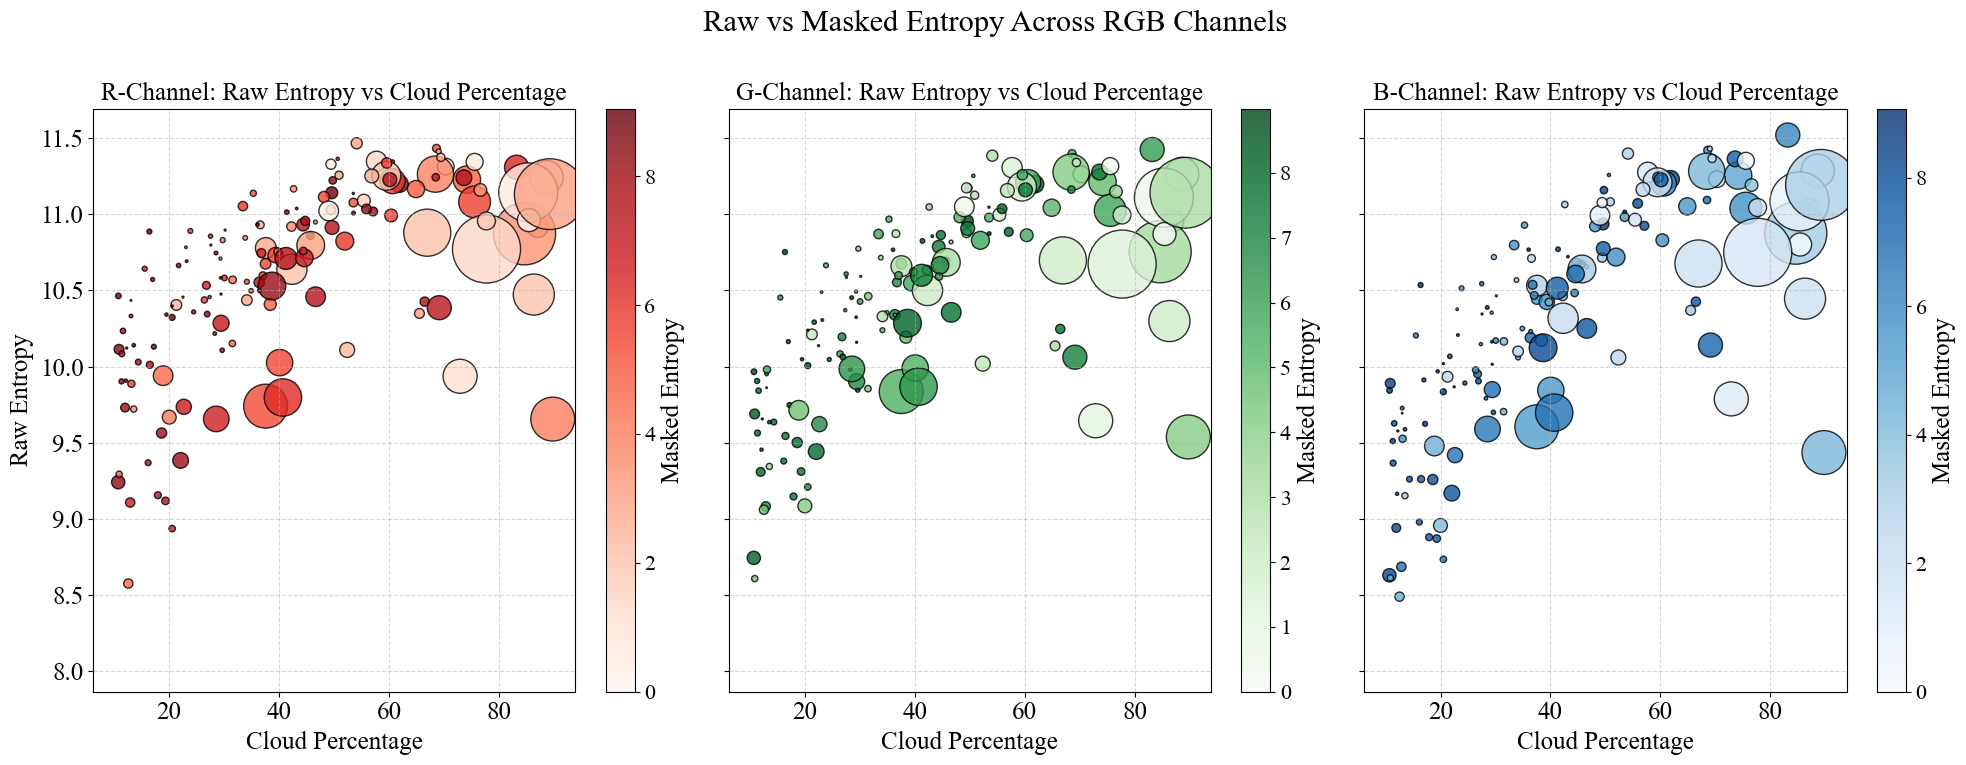

In [11]:
plt.rcParams['font.family'] = 'Times New Roman'

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

filtered_merged_df = df[(df['cloud_percentage'] > 10) & (df['cloud_percentage'] < 90)]

bands = ['R', 'G', 'B']
colors = ['Reds', 'Greens', 'Blues']

for i, (band, cmap) in enumerate(zip(bands, colors)):
    ax = axes[i]
    sc = ax.scatter(
        filtered_merged_df['cloud_percentage'],
        filtered_merged_df[f'raw_{band}_entropy'],
        s=filtered_merged_df["delta_no"], # Scale the size of the points
        c=filtered_merged_df[f'masked_{band}_entropy'],
        cmap=cmap,
        alpha=0.8,
        edgecolors='k'
    )
    ax.set_xlabel('Cloud Percentage', fontsize=18)
    ax.set_title(f'{band}-Channel: Raw Entropy vs Cloud Percentage', fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Create colorbar and set label
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(f'Masked Entropy', fontsize=18)  
    
    # Set colorbar tick parameters to increase size
    cbar.ax.tick_params(labelsize=16)  
    
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

axes[0].set_ylabel('Raw Entropy', fontsize=18)  # Increased font size for consistency
plt.suptitle('Raw vs Masked Entropy Across RGB Channels\n', fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 1])
# plt.savefig("Figure8.png", dpi=300)
plt.show()